# **5 Sparse Logistic Regression (Ray)**
**5.1**

Reading 'spectf.csv'. Separating the SPECTF data into a test set and training set

In [855]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
data_raw = pd.read_csv('spectf.csv')
data_train, data_test = train_test_split(data_raw, test_size=0.25, random_state=2)
# print(data_raw)
# print(data_train)
# print(data_test)

Plotting ROC curves for all the individual features.

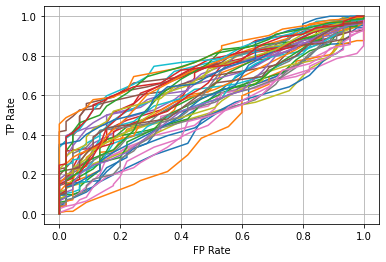

In [856]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
# parameters for the LogisticRegression
penalty = 'l1'
solver = 'liblinear'
max_iter = 1000
# global parameters for my algorithm
auc_bound = 0.1
auc_bound2 = 0.3
auc_bound3 = 0.3
num2 = 15
num3 = 12
# algorithm starting here
y_train = data_train.iloc[:, 0]
number_feat = len(data_train.iloc[1, 1:])
auc_value = []
for i in range(number_feat):
    X_train = np.array(data_train.iloc[:, i+1]).reshape(-1, 1)
    log_reg = LogisticRegression(random_state=0, penalty=penalty,
                                 solver=solver, max_iter=max_iter).fit(X_train, y_train)
    y_pred = log_reg.predict_proba(X_train)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y_train, dtype=int),  y_pred)
    auc_value.append(metrics.roc_auc_score(y_train, y_pred))
    # print(f'#{i}: {auc}), score={log_reg.score(X_train, y_train)}')
    plt.plot(fpr,tpr)
    plt.ylabel('TP Rate')
    plt.xlabel('FP Rate')
plt.grid(True)
plt.show()

**5.2**

Function return the data of the required subset.

In [857]:
def data_subset(data, subset):
    subset = np.array(subset)
    if len(subset) == 1:
        return np.array(data.iloc[:, subset + 1]).reshape(-1, 1)
    else:
        return np.array(data.iloc[:, subset + 1])
# data_subset(data_train, [0, 5, 6])

Creating the subsets.

1) Check if there are very high correlated features. For that we calculate Pearson
correlation coefficients and remove all features that have abs(coeff)>0.9.
There are no such features.

In [858]:
# deleting all low auc features
data_train_np = np.array(data_train)
corr = np.corrcoef(data_train_np[:, 1:].T)
for ind, row in enumerate(corr):
    for i in range(ind + 1, number_feat):
        if abs(row[i]) > 0.9:
            print('Correlated features:', ind, i, row[i])

2) Now lets start with the best features. For that we will
drop all features that give us AUC near 0.5 ($0.4\leq AUC\leq0.6$).
(The value 'auc_bound', controlling this boundary, was optimized through values from 0 up to 0.25)

It will give us 27 feature.

In [859]:
# auc_bound = 0.05
final_subsets = []
numbers_feat_good = []
for ind, auc in enumerate(auc_value):
    if np.abs(auc - 0.5) > auc_bound: ################### ОТРИЦАТЕЛЬНЫЕ
        numbers_feat_good.append(ind)
        final_subsets.append(np.array([ind]))
# data_train_good = data_subset(data_train, numbers_feat_good)
print(len(numbers_feat_good))

27


3) Looking at all combinations of 2 features. Calculating how many times each feature gives us good
performance ($AUC\leq0.2$ or $AUC\geq0.8$). Then select only the best features (first 15 features).

(Both parameters were optimized via ranges of values)

In [860]:
from collections import Counter
from itertools import combinations as comb
numbers_feat_good = numbers_feat_good
# auc_bound2 = 0.25
numbers_feat_good2 = []
for subset in comb(numbers_feat_good, 2):
    data_train_good = data_subset(data_train, subset)
    log_reg = LogisticRegression(random_state=0, penalty=penalty, max_iter=max_iter,
                                 solver=solver).fit(data_train_good, y_train)
    y_pred = log_reg.predict_proba(data_train_good)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y_train, dtype=int),  y_pred)
    auc = metrics.roc_auc_score(y_train, y_pred)
    if np.abs(auc - 0.5) > auc_bound2:
        numbers_feat_good2 = np.append(numbers_feat_good2, np.array(subset))
        final_subsets.append(np.array(subset))
    # plt.plot(fpr,tpr)
    # plt.ylabel('TP Rate')
    # plt.xlabel('FP Rate')
# plt.grid(True)
# plt.show()
counts = Counter(np.sort(numbers_feat_good2))
# print(counts.keys())
to_sort = np.array(list(counts.items()))
final_features = to_sort[to_sort[:, 1].argsort()][::-1]
print(final_features)
numbers_feat_good2 = final_features[:num2, 0]
print(numbers_feat_good2)

[[41. 11.]
 [42.  7.]
 [39.  7.]
 [ 3.  6.]
 [ 5.  3.]
 [33.  2.]
 [31.  2.]
 [29.  2.]
 [25.  2.]
 [ 9.  2.]
 [37.  1.]
 [32.  1.]
 [28.  1.]
 [15.  1.]
 [14.  1.]
 [ 1.  1.]]
[41. 42. 39.  3.  5. 33. 31. 29. 25.  9. 37. 32. 28. 15. 14.]


4) Looking at all combinations of 3 features using the best parameters
from the step 3. Calculating how many times each feature gives us good
performance ($AUC\leq0.2$ or $AUC\geq0.8$). Then select only the best features
(first 12 features - this
number gives us all features that perform good at least most of the times out of all subsets).

In [861]:
# auc_bound3 = 0.3
numbers_feat_good3 = []
for subset in comb(numbers_feat_good2, 3):
    data_train_good = data_subset(data_train, subset)
    log_reg = LogisticRegression(random_state=0, penalty=penalty, max_iter=max_iter,
                                 solver=solver).fit(data_train_good, y_train)
    y_pred = log_reg.predict_proba(data_train_good)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y_train, dtype=int),  y_pred)
    auc = metrics.roc_auc_score(y_train, y_pred)
    if np.abs(auc - 0.5) > auc_bound3:
        numbers_feat_good3 = np.append(numbers_feat_good3, np.array(subset))
        final_subsets.append(np.array(subset))
    # plt.plot(fpr,tpr)
    # plt.ylabel('TP Rate')
    # plt.xlabel('FP Rate')
# plt.grid(True)
# plt.show()
counts = Counter(np.sort(numbers_feat_good3))
to_sort = np.array(list(counts.items()))
final_features = to_sort[to_sort[:, 1].argsort()][::-1]
print(final_features)
numbers_feat_good3 = final_features[:num3, 0]
print(numbers_feat_good3)

[[41. 85.]
 [42. 72.]
 [39. 71.]
 [ 3. 59.]
 [25. 44.]
 [ 5. 39.]
 [33. 37.]
 [15. 37.]
 [ 9. 37.]
 [31. 36.]
 [29. 33.]
 [14. 33.]
 [28. 28.]
 [37. 26.]
 [32. 26.]]
[41. 42. 39.  3. 25.  5. 33. 15.  9. 31. 29. 14.]


5) Not, for the final subset, let's select the best 2, 3, 4, and 5 features and for each of them we
 will add 0/2/5, 0/3/6, and 0/4/8, and 0/5/10 least correlated features, respectively. In the end, we will
  look at 12 combinations and select the best one.

In [862]:
def find_least_corr(feature, number, corr, numbers):
    index = feature
    if not number:
        return None
    ans = []
    for i in range(number):
        index_min = np.abs(corr[index]).argmin()
        # print(np.abs(corr[index]), index_min)
        ans.append(numbers[index_min])
        corr[index, index_min] = 10
    return ans

data_train_good3 = data_subset(data_train, numbers_feat_good3)
numbers_feat_good4 = np.array(numbers_feat_good3, dtype=int)
corr = np.corrcoef(data_train_good3.T)
best_combinations = []
for num_f in [2, 3, 4, 5]:
    for num_cor in [0, 1, 2]:
        combin = numbers_feat_good4[:num_f]
        for c in np.copy(combin):
            index_c = np.where(numbers_feat_good4 == c)
            least_corr_els = find_least_corr(index_c, num_cor, corr, numbers_feat_good4)
            if least_corr_els is not None:
                combin = np.append(combin, np.array(least_corr_els))
        best_combinations.append(combin)
        final_subsets.append(np.array(combin))

**5.3**

Training and plotting 300 ROC curves for the subsets we created and calculating their AUCs.

The best AUC value I can achieve is for the features: 34  4  6 40 42 43 10 26.
AUC  for the training data is equal to 0.88.

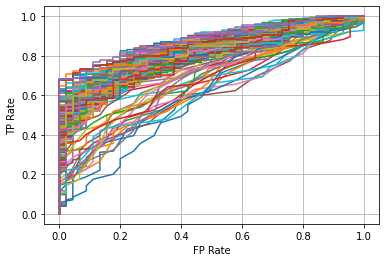

The highest AUC=0.8784992784992784 is for the combination of feature:
[34  4  6 40 42 43 10 26]


In [863]:
# removing the worst subsets, starting from single features to have 300 subsets in the end.
final_subsets = final_subsets[-300:]
# for i in range(len(final_subsets)):
#     if dtype(final_subsets[i]) == int:
#         final_subsets[i] = [final_subsets[i]]

aucs = []
for ind, subset in enumerate(final_subsets):
    # print(subset)
    subset = np.array(list(set(subset)))
    data_train_good = data_subset(data_train, subset)
    log_reg = LogisticRegression(random_state=0, penalty=penalty, max_iter=max_iter,
                                 solver=solver).fit(data_train_good, y_train)
    y_pred = log_reg.predict_proba(data_train_good)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y_train, dtype=int),  y_pred)
    auc = metrics.roc_auc_score(y_train, y_pred)
    # print(f'{ind}: combination of features: {subset + 1}, auc={auc}')
    aucs.append(auc)
    plt.plot(fpr,tpr)
    plt.ylabel('TP Rate')
    plt.xlabel('FP Rate')
plt.grid(True)
plt.show()
ind_best_auc = np.array(aucs).argmax()
subset_best = np.array(list(set(final_subsets[ind_best_auc])))
print(f'The highest AUC={aucs[ind_best_auc]}'
      f' is for the combination of feature:\n{subset_best + 1}')

**5.4**

Now let's try to use it for the test data.

Using the same classifier on the test data we can achieve AUC=0.85.

0.8543859649122807


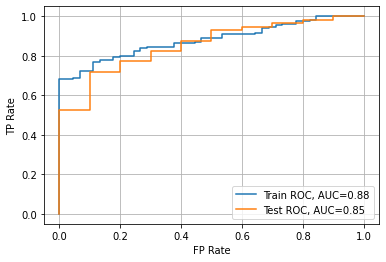

In [864]:
# for ind, subset_best in enumerate(best_combinations):
data_train_good = data_subset(data_train, subset_best)
log_reg = LogisticRegression(random_state=0, penalty=penalty, solver=solver,
                             max_iter=max_iter).fit(data_train_good, y_train)

y_pred = log_reg.predict_proba(data_train_good)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_train, dtype=int),  y_pred)
auc = metrics.roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr, label=f'Train ROC, AUC={round(auc, 2)}')
y_test = data_test.iloc[:, 0]
data_test_good = data_subset(data_test, subset_best)
y_pred = log_reg.predict_proba(data_test_good)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_test, dtype=int),  y_pred)
auc2 = metrics.roc_auc_score(y_test, y_pred)
print(auc2)
plt.plot(fpr,tpr, label=f'Test ROC, AUC={round(auc2, 2)}')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.grid(True)
plt.legend()
plt.show()

On top of the code I can change regularization from l1 to l2. Doing that and decreasing auc_bounds in
order to get 300 subsets I get the training AUC=82%, and testing AUC=78%. So it still performs not that bad
and may do better with some extra parameters optimization. But for know l1 regularization works
better for the case of high number of features.